In [1]:
from simulation.simulator import *
import time
import matplotlib.pyplot as plt

[Taichi] version 1.7.1, llvm 15.0.1, commit 0f143b2f, win, python 3.11.9
Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
def simp_update_wavefront(pos: list[np.ndarray], dir: list[np.ndarray], grad_xyz: tuple[np.ndarray, np.ndarray, np.ndarray], 
                     IOR: np.ndarray, delta_t: float) -> tuple[list[np.ndarray], list[np.ndarray]]:
    new_pos = []
    new_dir = []
    grad_x, grad_y, grad_z = grad_xyz
    for (x,y,z), (dx, dy, dz) in zip(pos, dir):
        # x_i+1 = x_i + delta_t * v_i / n^2
        # v_i+1 = v_i + delta_t * grad_n / n
        n = IOR[int(x), int(y), int(z)]

        new_x = x + delta_t * dx / n**2
        new_y = y + delta_t * dy / n**2
        new_z = z + delta_t * dz / n**2

        new_x = np.clip(new_x, 0, IOR.shape[0]-1)
        new_y = np.clip(new_y, 0, IOR.shape[1]-1)
        new_z = np.clip(new_z, 0, IOR.shape[2]-1)
        
        new_pos.append((new_x, new_y, new_z))

        n_dx = grad_x[int(x), int(y), int(z)]
        n_dy = grad_y[int(x), int(y), int(z)]
        n_dz = grad_z[int(x), int(y), int(z)]
        new_dx = dx + delta_t * n_dx / n
        new_dy = dy + delta_t * n_dy / n
        new_dz = dz + delta_t * n_dz / n
        new_dir.append((new_dx, new_dy, new_dz))

    return new_pos, new_dir

## Without cuda

In [19]:
def benchmark(num_points, grid_size=128, num_iterations=100):
    # Generate random input data
    pos = torch.rand(num_points, 3) * grid_size
    dir = torch.rand(num_points, 3)
    dir /= dir.norm(dim=1, keepdim=True)
    within_mask = torch.ones(num_points, dtype=torch.bool)
    grad_xyz = torch.rand(grid_size, grid_size, grid_size, 3)
    IOR = torch.rand(grid_size, grid_size, grid_size)
    step_size = 0.1

    # Convert torch tensors to numpy arrays for simp_update_wavefront
    pos_np = pos.numpy()
    dir_np = dir.numpy()
    grad_xyz_np = (grad_xyz[:,:,:,0].numpy(), grad_xyz[:,:,:,1].numpy(), grad_xyz[:,:,:,2].numpy())
    IOR_np = IOR.numpy()

    # Benchmark update_wavefront
    start_time = time.time()
    for _ in range(num_iterations):
        pos, dir, within_mask = update_wavefront(pos, dir, within_mask, grad_xyz, IOR, step_size)
    torch_time = time.time() - start_time

    # Benchmark simp_update_wavefront
    start_time = time.time()
    for _ in range(num_iterations):
        pos_np, dir_np = simp_update_wavefront(pos_np.tolist(), dir_np.tolist(), grad_xyz_np, IOR_np, step_size)
        pos_np = np.array(pos_np)
        dir_np = np.array(dir_np)
    numpy_time = time.time() - start_time

    return torch_time, numpy_time

def run_benchmarks_list(num_points_range):
    
    torch_times = []
    numpy_times = []

    for num_points in num_points_range:
        torch_time, numpy_time = benchmark(num_points)
        torch_times.append(torch_time)
        numpy_times.append(numpy_time)
        print(f"Completed benchmark for {num_points} points")
    return torch_times, numpy_times

 
# num_points_range = [10, 50, 100, 500, 1000, 5000, 10000, 50000]
num_points_range = [int(10**(i/10)) for i in range(10, 50, 4)]
print(num_points_range)
torch_times, numpy_times = run_benchmarks_list(num_points_range)

[10, 25, 63, 158, 398, 1000, 2511, 6309, 15848, 39810]
Completed benchmark for 10 points
Completed benchmark for 25 points
Completed benchmark for 63 points
Completed benchmark for 158 points
Completed benchmark for 398 points
Completed benchmark for 1000 points
Completed benchmark for 2511 points
Completed benchmark for 6309 points
Completed benchmark for 15848 points
Completed benchmark for 39810 points


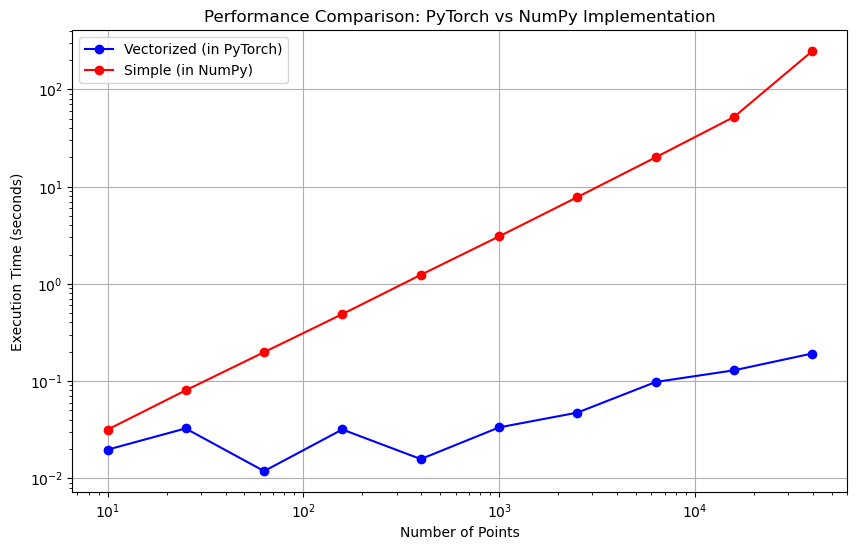

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(num_points_range, torch_times, 'b-o', label='Vectorized (in PyTorch)')
plt.plot(num_points_range, numpy_times, 'r-o', label='Simple (in NumPy)')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of Points')
plt.ylabel('Execution Time (seconds)')
plt.title('Performance Comparison: PyTorch vs NumPy Implementation')
plt.legend()
plt.grid(True)
save_path = os.path.join(os.getcwd(), "images", 'Compare vectorization.png')
plt.savefig(save_path, dpi=300)
plt.show()

## With cuda

In [ ]:
def benchmark_cuda(num_points, grid_size=128, num_iterations=100):
    # Generate random input data
    pos = torch.rand(num_points, 3) * grid_size
    dir = torch.rand(num_points, 3)
    dir /= dir.norm(dim=1, keepdim=True)
    within_mask = torch.ones(num_points, dtype=torch.bool)
    grad_xyz = torch.rand(grid_size, grid_size, grid_size, 3)
    IOR = torch.rand(grid_size, grid_size, grid_size)
    step_size = 0.1

    # Convert torch tensors to numpy arrays for simp_update_wavefront
    pos_np = pos.numpy()
    dir_np = dir.numpy()
    grad_xyz_np = (grad_xyz[:,:,:,0].numpy(), grad_xyz[:,:,:,1].numpy(), grad_xyz[:,:,:,2].numpy())
    IOR_np = IOR.numpy()

    # Benchmark update_wavefront
    pos = pos.cuda()
    dir = dir.cuda()
    within_mask = within_mask.cuda()
    grad_xyz = grad_xyz.cuda()
    IOR = IOR.cuda()
    start_time = time.time()
    for _ in range(num_iterations):
        pos, dir, within_mask = update_wavefront(pos, dir, within_mask, grad_xyz, IOR, step_size)
    torch_time = time.time() - start_time

    # Benchmark simp_update_wavefront
    start_time = time.time()
    for _ in range(num_iterations):
        pos_np, dir_np = simp_update_wavefront(pos_np.tolist(), dir_np.tolist(), grad_xyz_np, IOR_np, step_size)
        pos_np = np.array(pos_np)
        dir_np = np.array(dir_np)
    numpy_time = time.time() - start_time

    return torch_time, numpy_time

def run_benchmarks_and_plot_cuda():
    num_points_range = [10, 100, 1000, 10000, 50000]
    torch_times = []
    numpy_times = []

    for num_points in num_points_range:
        torch_time, numpy_time = benchmark_cuda(num_points)
        torch_times.append(torch_time)
        numpy_times.append(numpy_time)
        print(f"Completed benchmark for {num_points} points")

    plt.figure(figsize=(10, 6))
    plt.plot(num_points_range, torch_times, 'b-o', label='update_wavefront (PyTorch)')
    plt.plot(num_points_range, numpy_times, 'r-o', label='simp_update_wavefront (NumPy)')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Number of Points')
    plt.ylabel('Execution Time (seconds)')
    plt.title('Performance Comparison: PyTorch vs NumPy Implementation')
    plt.legend()
    plt.grid(True)
    plt.show()

run_benchmarks_and_plot_cuda()